In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [2]:
# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths for the images and assign labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        
        # 0 for real, 1 for fake
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
# from torchvision import transforms

# # Enhanced Data Augmentation for Training
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resizes images to 224x224
#     transforms.RandomHorizontalFlip(),  # Flip images horizontally
#     transforms.RandomRotation(15),  # Rotate images by up to 15 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Change brightness, contrast, etc.
#     transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Small affine transformations (rotation, translation, etc.)
#     transforms.RandomCrop(224, padding=10),  # Random crop with padding for more variance
#     transforms.ToTensor(),  # Converts image to tensor, scales pixel values to [0, 1]
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats THIS IS KEY HERE AS WE ARE USING A PRETRAINED MODEL
# ])

# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

### More Robust Data Augmentations

In [4]:
# Adjusted Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.2),  # Flip images vertically with a probability of 0.2 (new addition)
    transforms.RandomRotation(30),  # Increase rotation variability to up to 30 degrees
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # More variance in color adjustments
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Slightly more affine transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # RandomResizedCrop for more variability in object sizes
    transforms.ToTensor(),  # Converts image to tensor, scales pixel values to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# No changes needed for validation/test set as data augmentation is only for training
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
from sklearn.model_selection import train_test_split

# Define paths to your real and fake image directories
real_dir = 'final_cleaned_dataset/resized_data/rezised_real' # GAN Data has been added to this
fake_dir = 'final_cleaned_dataset/resized_data/rezised_fake' # GAN Data has been added to this
# gan_real = 'celebrity_pairs/celebrity_dataset_real'
# gan_fake = 'celebrity_pairs/celebrity_dataset_real'

# Create the full dataset
full_dataset = ImageDataset(real_dir, fake_dir, transform=train_transform)

# Split the dataset into training (70%), validation (15%), and testing (15%)
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42, stratify=full_dataset.labels)
# Using stratification to ensure the class balance remains consistent between the training and testing sets.
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42, stratify=[full_dataset.labels[i] for i in test_indices]) 

# Create Subsets for train/val/test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Load the pretrained ViT model for binary classification
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)

# Move the model to the GPU if available (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mps


# **Next 4 Cells used for Training - Do Not Run When Evaluating / Testing**

## **Partial Fine-Tuning with Layer Unfreezing**
To adapt the ViT to our specific deepfake detection task, we employed **transfer learning**, where we leveraged the pretrained ViT model and fine-tuned it on our smaller dataset. Specifically:
- We **modified the output classifier** to handle **binary classification** by changing the output dimensions from 1000 classes to 2 classes.
- Initially, we froze most of the ViT model, only allowing the classifier to be trained. This approach is efficient when limited data is available and helps retain most of the knowledge learned from the large-scale dataset.
  
However, to further adapt the model to our data, we decided to **unfreeze the last 6 encoder layers**, allowing them to be trained on our dataset. This was done to let the model learn more specific features from our deepfake images. By doing so, the model could better differentiate between real and fake images.

- The first 6 layers (encoder layers 0-5) remained **frozen**, keeping their pretrained weights intact. These layers typically extract more generic, low-level features from the images, which are generally useful across different tasks.
- The last 6 layers (encoder layers 6-11) were **unfrozen**, allowing the model to learn task-specific features, which are more refined and essential for distinguishing deepfakes in our dataset.

By unfreezing the last 6 encoder layers and the classifier, we allowed the model to adjust its representations to better fit the nuances of our binary classification task while still benefiting from the robust, general features learned in the earlier layers.

This fine-tuning approach strikes a balance between using pretrained knowledge and adapting the model to our specific deepfake detection task, enhancing performance while avoiding overfitting.

In [7]:
# Unfreeze the last 6 encodder  layers of the ViT encoder and the classifier
for name, param in model.named_parameters():
    if 'encoder.layer.6' in name or 'encoder.layer.7' in name or 'encoder.layer.8' in name or 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'classifier' in name:
        param.requires_grad = True  # Unfreeze these layers
    else:
        param.requires_grad = False  # Keep other layers frozen

In [8]:
def train_model(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=10,    # Number of epochs to train for
    patience=12,      # Early stopping patience (stop if no improvement after this many epochs)
    model_save_path='best_model.pth'  # Path to save the best model
):
    # Define the optimizer with different learning rates for classifier and the last three layers
    optimizer = optim.AdamW([
        {'params': model.vit.encoder.layer[-6:].parameters(), 'lr': 1e-5},  # Lower LR for the last 6 encoder layers
        {'params': model.classifier.parameters(), 'lr': 1e-4}              # Higher LR for the classifier
    ])

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_recall = 0.0  # To track the model with the best recall
    best_epoch = 0         # To track the best epoch for early stopping
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with tqdm progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images).logits
                loss = loss_fn(val_outputs, val_labels)

                # Track validation loss and accuracy
                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                # Collect labels and predictions for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        # Calculate average validation loss and accuracy
        epoch_val_loss = val_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculate precision, recall, f1, and support using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
        print(f'Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1-Score: {f1:.4f}')

        # Dynamic LR adjustment based on validation loss
        scheduler.step(epoch_val_loss)

        # Save the model if it has the best recall
        if recall > best_val_recall:
            best_val_recall = recall
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved best model with validation recall: {best_val_recall:.4f}')
            early_stopping_counter = 0  # Reset early stopping counter if improvement
        else:
            early_stopping_counter += 1  # No improvement, increment counter

        # Early stopping
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs of no improvement.")
            break

    print(f"Best model saved from epoch {best_epoch} with recall: {best_val_recall:.4f}")

    # Visualize loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load the best model before returning
    model.load_state_dict(torch.load(model_save_path))
    return model

In [9]:
# Output the sizes of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 9262
Validation set size: 1985
Test set size: 1985


Epoch 1/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch [1/100]
Train Loss: 0.5945, Train Accuracy: 0.6630
Val Loss: 0.5099, Val Accuracy: 0.7295
Val Precision: 0.7271, Val Recall: 0.7351, Val F1-Score: 0.7311
Saved best model with validation recall: 0.7351


Epoch 2/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Epoch [2/100]
Train Loss: 0.4612, Train Accuracy: 0.7684
Val Loss: 0.4367, Val Accuracy: 0.7763
Val Precision: 0.7776, Val Recall: 0.7744, Val F1-Score: 0.7760
Saved best model with validation recall: 0.7744


Epoch 3/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Epoch [3/100]
Train Loss: 0.4099, Train Accuracy: 0.7984
Val Loss: 0.3862, Val Accuracy: 0.8050
Val Precision: 0.7930, Val Recall: 0.8258, Val F1-Score: 0.8091
Saved best model with validation recall: 0.8258


Epoch 4/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch [4/100]
Train Loss: 0.3711, Train Accuracy: 0.8215
Val Loss: 0.3847, Val Accuracy: 0.8060
Val Precision: 0.8393, Val Recall: 0.7573, Val F1-Score: 0.7962


Epoch 5/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]


Epoch [5/100]
Train Loss: 0.3399, Train Accuracy: 0.8391
Val Loss: 0.3540, Val Accuracy: 0.8267
Val Precision: 0.8405, Val Recall: 0.8066, Val F1-Score: 0.8232


Epoch 6/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


Epoch [6/100]
Train Loss: 0.3274, Train Accuracy: 0.8458
Val Loss: 0.3385, Val Accuracy: 0.8398
Val Precision: 0.8788, Val Recall: 0.7885, Val F1-Score: 0.8312


Epoch 7/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


Epoch [7/100]
Train Loss: 0.3051, Train Accuracy: 0.8613
Val Loss: 0.3442, Val Accuracy: 0.8307
Val Precision: 0.8262, Val Recall: 0.8379, Val F1-Score: 0.8320
Saved best model with validation recall: 0.8379


Epoch 8/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


Epoch [8/100]
Train Loss: 0.2893, Train Accuracy: 0.8700
Val Loss: 0.3332, Val Accuracy: 0.8363
Val Precision: 0.8151, Val Recall: 0.8701, Val F1-Score: 0.8417
Saved best model with validation recall: 0.8701


Epoch 9/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [9/100]
Train Loss: 0.2855, Train Accuracy: 0.8714
Val Loss: 0.2905, Val Accuracy: 0.8610
Val Precision: 0.8842, Val Recall: 0.8308, Val F1-Score: 0.8567


Epoch 10/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


Epoch [10/100]
Train Loss: 0.2637, Train Accuracy: 0.8812
Val Loss: 0.3059, Val Accuracy: 0.8569
Val Precision: 0.8808, Val Recall: 0.8258, Val F1-Score: 0.8524


Epoch 11/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [11/100]
Train Loss: 0.2638, Train Accuracy: 0.8818
Val Loss: 0.3027, Val Accuracy: 0.8524
Val Precision: 0.8889, Val Recall: 0.8056, Val F1-Score: 0.8452


Epoch 12/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [12/100]
Train Loss: 0.2538, Train Accuracy: 0.8850
Val Loss: 0.2653, Val Accuracy: 0.8751
Val Precision: 0.8917, Val Recall: 0.8540, Val F1-Score: 0.8724


Epoch 13/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [13/100]
Train Loss: 0.2519, Train Accuracy: 0.8859
Val Loss: 0.2680, Val Accuracy: 0.8680
Val Precision: 0.8637, Val Recall: 0.8741, Val F1-Score: 0.8689
Saved best model with validation recall: 0.8741


Epoch 14/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [14/100]
Train Loss: 0.2350, Train Accuracy: 0.8915
Val Loss: 0.2594, Val Accuracy: 0.8776
Val Precision: 0.8684, Val Recall: 0.8902, Val F1-Score: 0.8792
Saved best model with validation recall: 0.8902


Epoch 15/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [15/100]
Train Loss: 0.2276, Train Accuracy: 0.8990
Val Loss: 0.2613, Val Accuracy: 0.8796
Val Precision: 0.8755, Val Recall: 0.8852, Val F1-Score: 0.8803


Epoch 16/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [16/100]
Train Loss: 0.2252, Train Accuracy: 0.8972
Val Loss: 0.2645, Val Accuracy: 0.8715
Val Precision: 0.8712, Val Recall: 0.8721, Val F1-Score: 0.8717


Epoch 17/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [17/100]
Train Loss: 0.2198, Train Accuracy: 0.9026
Val Loss: 0.2450, Val Accuracy: 0.8786
Val Precision: 0.8701, Val Recall: 0.8902, Val F1-Score: 0.8800


Epoch 18/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


Epoch [18/100]
Train Loss: 0.2207, Train Accuracy: 0.8997
Val Loss: 0.2711, Val Accuracy: 0.8766
Val Precision: 0.8945, Val Recall: 0.8540, Val F1-Score: 0.8738


Epoch 19/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [19/100]
Train Loss: 0.2038, Train Accuracy: 0.9098
Val Loss: 0.2525, Val Accuracy: 0.8877
Val Precision: 0.8660, Val Recall: 0.9174, Val F1-Score: 0.8910
Saved best model with validation recall: 0.9174


Epoch 20/100 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


Epoch [20/100]
Train Loss: 0.1984, Train Accuracy: 0.9134
Val Loss: 0.2685, Val Accuracy: 0.8705
Val Precision: 0.8940, Val Recall: 0.8409, Val F1-Score: 0.8666


Epoch 21/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


Epoch [21/100]
Train Loss: 0.1976, Train Accuracy: 0.9127
Val Loss: 0.2637, Val Accuracy: 0.8771
Val Precision: 0.9147, Val Recall: 0.8318, Val F1-Score: 0.8713


Epoch 22/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [22/100]
Train Loss: 0.1950, Train Accuracy: 0.9139
Val Loss: 0.2450, Val Accuracy: 0.8791
Val Precision: 0.8815, Val Recall: 0.8761, Val F1-Score: 0.8788


Epoch 23/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [23/100]
Train Loss: 0.1994, Train Accuracy: 0.9113
Val Loss: 0.2497, Val Accuracy: 0.8882
Val Precision: 0.8946, Val Recall: 0.8802, Val F1-Score: 0.8873


Epoch 24/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [24/100]
Train Loss: 0.1850, Train Accuracy: 0.9201
Val Loss: 0.2852, Val Accuracy: 0.8786
Val Precision: 0.8514, Val Recall: 0.9174, Val F1-Score: 0.8832


Epoch 25/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [25/100]
Train Loss: 0.1855, Train Accuracy: 0.9213
Val Loss: 0.2455, Val Accuracy: 0.8872
Val Precision: 0.8849, Val Recall: 0.8902, Val F1-Score: 0.8876


Epoch 26/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [26/100]
Train Loss: 0.1851, Train Accuracy: 0.9190
Val Loss: 0.2453, Val Accuracy: 0.8861
Val Precision: 0.8824, Val Recall: 0.8912, Val F1-Score: 0.8868


Epoch 27/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


Epoch [27/100]
Train Loss: 0.1810, Train Accuracy: 0.9203
Val Loss: 0.2325, Val Accuracy: 0.8861
Val Precision: 0.8749, Val Recall: 0.9013, Val F1-Score: 0.8879


Epoch 28/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch [28/100]
Train Loss: 0.1862, Train Accuracy: 0.9184
Val Loss: 0.2355, Val Accuracy: 0.8942
Val Precision: 0.8999, Val Recall: 0.8872, Val F1-Score: 0.8935


Epoch 29/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch [29/100]
Train Loss: 0.1723, Train Accuracy: 0.9220
Val Loss: 0.2318, Val Accuracy: 0.8942
Val Precision: 0.8959, Val Recall: 0.8922, Val F1-Score: 0.8940


Epoch 30/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch [30/100]
Train Loss: 0.1690, Train Accuracy: 0.9242
Val Loss: 0.2256, Val Accuracy: 0.9013
Val Precision: 0.9173, Val Recall: 0.8822, Val F1-Score: 0.8994


Epoch 31/100 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]

Epoch [31/100]
Train Loss: 0.1699, Train Accuracy: 0.9232
Val Loss: 0.2257, Val Accuracy: 0.8907
Val Precision: 0.9008, Val Recall: 0.8781, Val F1-Score: 0.8893
Early stopping triggered after 12 epochs of no improvement.
Best model saved from epoch 19 with recall: 0.9174


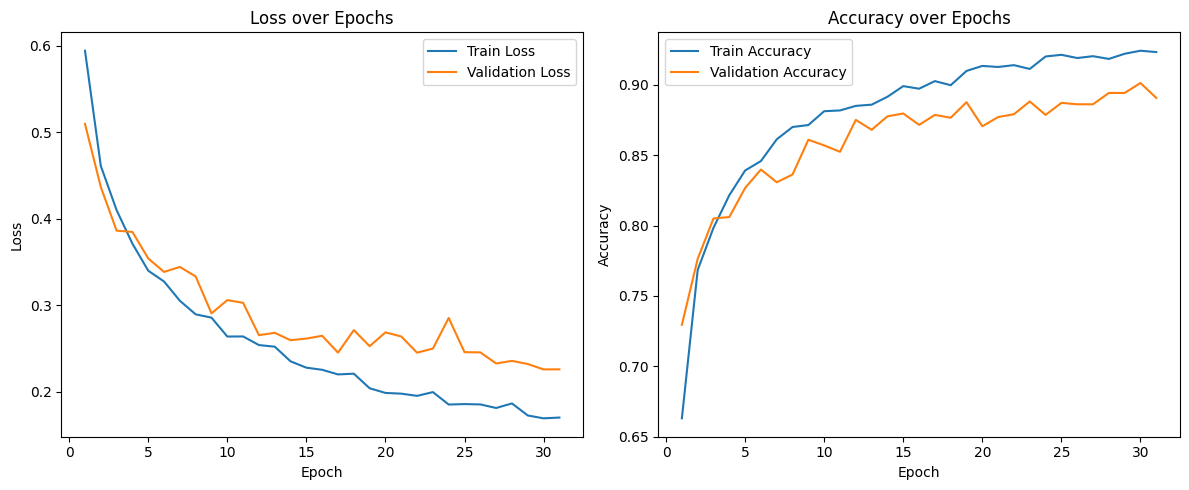

In [10]:
# Define number of epochs and model save path
num_epochs = 100
model_save_path = 'partial_tuning_unfreezing_6_layersbest_vit_model_fancy_tr_2.pth'  # Path to save the best model

# Call the train_model function without the lr argument
trained_model = train_model(
    model=model,              # Your initialized model (e.g., ViT)
    train_loader=train_loader,  # DataLoader for the training set
    val_loader=val_loader,      # DataLoader for the validation set
    device=device,              # Device (cpu or cuda)
    num_epochs=num_epochs,      # Number of epochs
    model_save_path=model_save_path  # Path to save the best model
)

## Understanding Positive and Negative Classes in Binary Classification

In binary classification, the dataset is divided into two distinct classes, often referred to as the **positive class** and the **negative class**. In the context of deepfake detection:

- **Positive Class (+ve)**: Fake images (deepfakes)
- **Negative Class (-ve)**: Real images

### Confusion Matrix

For a binary classification problem, the performance of the model is often evaluated using a **confusion matrix**. The confusion matrix represents the counts of true and false positives, and true and false negatives, and is structured as follows:

|                  | Predicted: Real (-ve) | Predicted: Fake (+ve) |
|------------------|-----------------------|-----------------------|
| **Actual: Real (-ve)** | True Negative (TN)   | False Positive (FP)   |
| **Actual: Fake (+ve)** | False Negative (FN)   | True Positive (TP)    |

### Key Definitions:
- **True Positive (TP)**: The number of correctly identified fake images (positive class).
- **False Positive (FP)**: The number of real images incorrectly classified as fake (type I error).
- **True Negative (TN)**: The number of correctly identified real images (negative class).
- **False Negative (FN)**: The number of fake images incorrectly classified as real (type II error).

### Precision, Recall, and F1-Score

Using the confusion matrix, we can derive key performance metrics:

#### Precision:
Precision measures the proportion of correctly predicted fake images (positive class) out of all predicted fake images.

$$\text{Precision} = \frac{TP}{TP + FP}$$

Where:
- \(TP\) = True Positives
- \(FP\) = False Positives

#### Recall (Sensitivity, True Positive Rate):
Recall measures the proportion of correctly predicted fake images (positive class) out of all actual fake images. This is crucial for deepfake detection since missing a fake (i.e., false negatives) can have severe consequences.

$$\text{Recall} = \frac{TP}{TP + FN}$$

Where:
- \(FN\) = False Negatives

#### F1-Score:
The F1-Score provides a harmonic mean between precision and recall, giving a balanced view of the model's performance when dealing with class imbalance.

$$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

The F1-Score becomes particularly important in cases where one class (e.g., fake images) is more important than the other.

### Accuracy
Accuracy is the proportion of correctly predicted instances (both real and fake) out of the total number of instances.

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

However, in the context of deepfake detection, **accuracy** might not be as informative if the dataset is imbalanced, which is why we rely more on **precision, recall, and F1-score**.

### ROC-AUC Score

The **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)** score provides a comprehensive view of the model’s performance. It plots the trade-off between **True Positive Rate (Recall)** and **False Positive Rate (FPR)**, where:

$$\text{FPR} = \frac{FP}{FP + TN}$$

The **AUC score** quantifies the area under this curve, with a value of **1** indicating a perfect classifier, and **0.5** indicating random guessing.

### Conclusion:
In deepfake detection, the **positive class** is defined as **fake images**, and the **negative class** is defined as **real images**. Metrics like **recall** are particularly important in this context, as it is critical to minimize the number of **false negatives** (i.e., classifying a fake image as real). The confusion matrix, along with precision, recall, and F1-score, provides a detailed understanding of the model's performance in detecting deepfakes.

# **Evaluation on Test Set - Run From Here**

In [22]:
# Load the saved model
model.load_state_dict(torch.load('partial_tuning_unfreezing_6_layersbest_vit_model_fancy_tr_2.pth'))
model.eval()  #

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [23]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Testing loop to evaluate on the test dataset
all_test_labels = []
all_test_predictions = []
all_test_probabilities = []
test_loss = 0.0
test_correct_predictions = 0
test_total_samples = 0
# Define loss function again for testing
loss_fn = nn.CrossEntropyLoss()


In [25]:
# Define the function to evaluate the model and visualize results
def evaluate_and_visualize_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0
    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []

    # Define a loss function (assuming CrossEntropyLoss was used during training)
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to compute gradients during testing
        for test_images, test_labels in tqdm(test_loader, desc="Testing the model"):
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images).logits
            test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
            loss = loss_fn(test_outputs, test_labels)

            # Track loss and accuracy
            test_loss += loss.item() * test_images.size(0)
            _, test_predicted = torch.max(test_outputs, 1)
            test_correct_predictions += (test_predicted == test_labels).sum().item()
            test_total_samples += test_labels.size(0)

            # Store labels and predictions for metrics
            all_test_labels.extend(test_labels.cpu().numpy())
            all_test_predictions.extend(test_predicted.cpu().numpy())
            all_test_probabilities.extend(test_probabilities)

    # Calculate overall test loss and accuracy
    test_loss = test_loss / test_total_samples
    test_accuracy = test_correct_predictions / test_total_samples

    # Calculate precision, recall, F1 score, and ROC-AUC score
    precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average='binary')
    roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)

    # Print metrics
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}')
    print(f'Test ROC-AUC: {roc_auc:.4f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Return metrics for further use
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_labels': all_test_labels,
        'test_predictions': all_test_predictions,
        'test_probabilities': all_test_probabilities
    }

# Function to plot and save the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, save_path='confusion_matrix.png'):
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    # Save the plot
    plt.savefig(os.path.join(os.getcwd(), save_path))  # Save in current directory
    
    plt.show()

# Function to plot and save the ROC-AUC curve
def plot_roc_curve(test_labels, test_probabilities, roc_auc, save_path='roc_auc_curve.png'):
    fpr, tpr, _ = roc_curve(test_labels, test_probabilities)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save the plot
    plt.savefig(os.path.join(os.getcwd(), save_path))  # Save in current directory
    
    plt.show()

Testing the model: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s]

Test Loss: 0.2535, Test Accuracy: 0.8816
Test Precision: 0.8567, Test Recall: 0.9163, Test F1-Score: 0.8855
Test ROC-AUC: 0.9636
Confusion Matrix:
[[841 152]
 [ 83 909]]


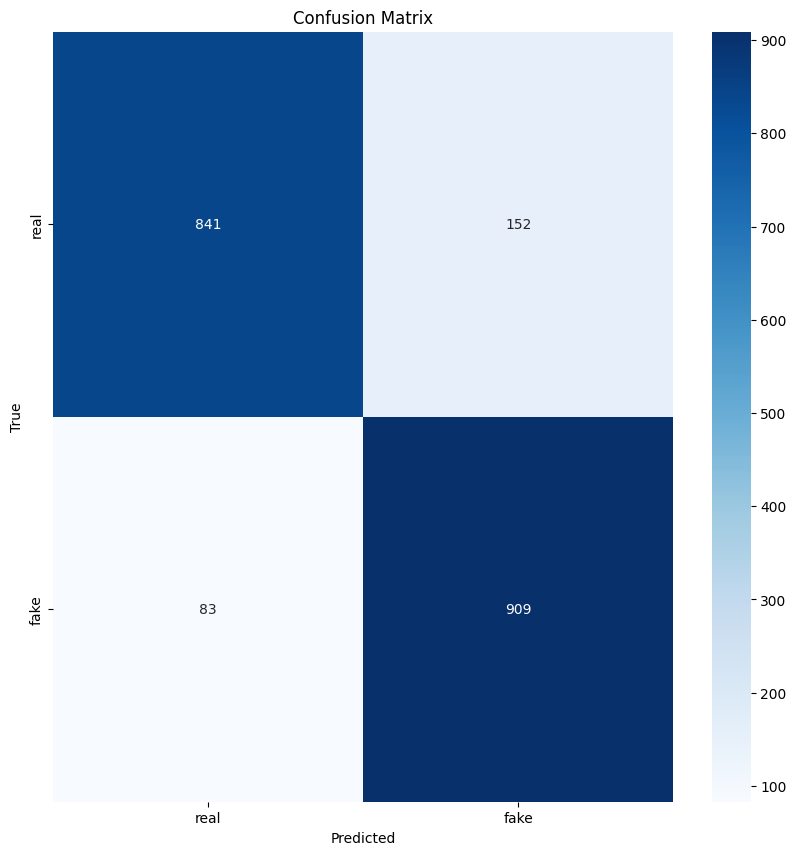

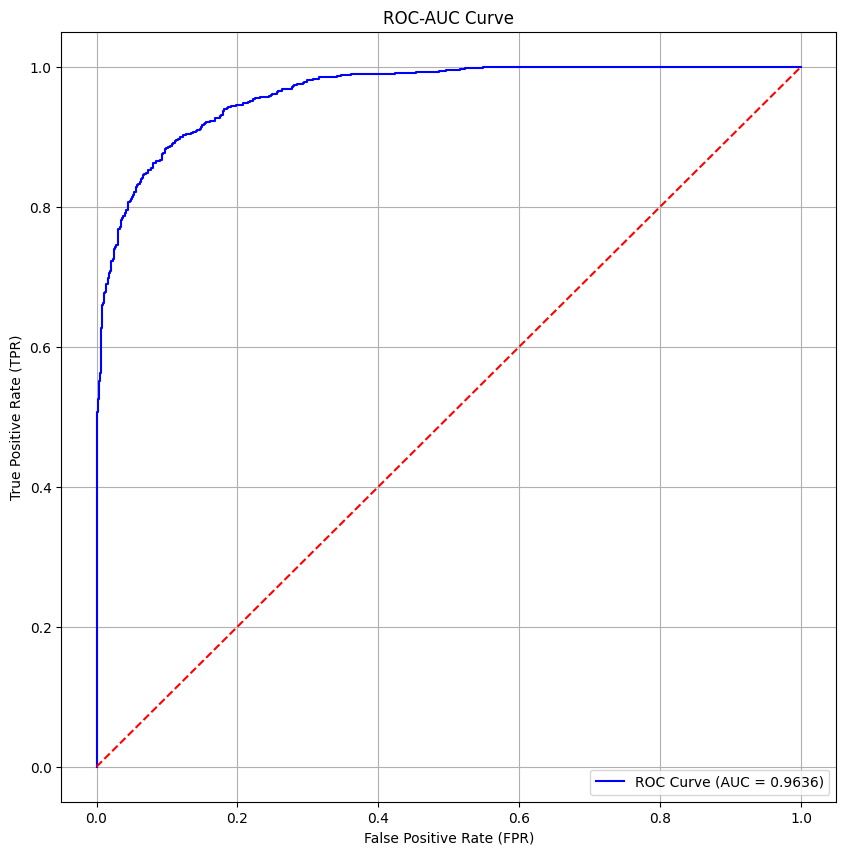

In [26]:
# # Evaluate the model and get results
results = evaluate_and_visualize_model(model, test_loader, device)

# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'], save_path='best_model_test_set_cf.png')

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'], save_path='best_model_test_set_roc.png')

### Combining val and test set and then testing model on a bigger test set

In [27]:
from torch.utils.data import ConcatDataset

# Combine val_dataset and test_dataset into a single larger dataset
combined_test_dataset = ConcatDataset([val_dataset, test_dataset])

# Create a DataLoader for the combined test dataset
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=True)

Testing the model: 100%|██████████| 125/125 [00:44<00:00,  2.81it/s]

Test Loss: 0.2562, Test Accuracy: 0.8829
Test Precision: 0.8578, Test Recall: 0.9179, Test F1-Score: 0.8868
Test ROC-AUC: 0.9627
Confusion Matrix:
[[1683  302]
 [ 163 1822]]


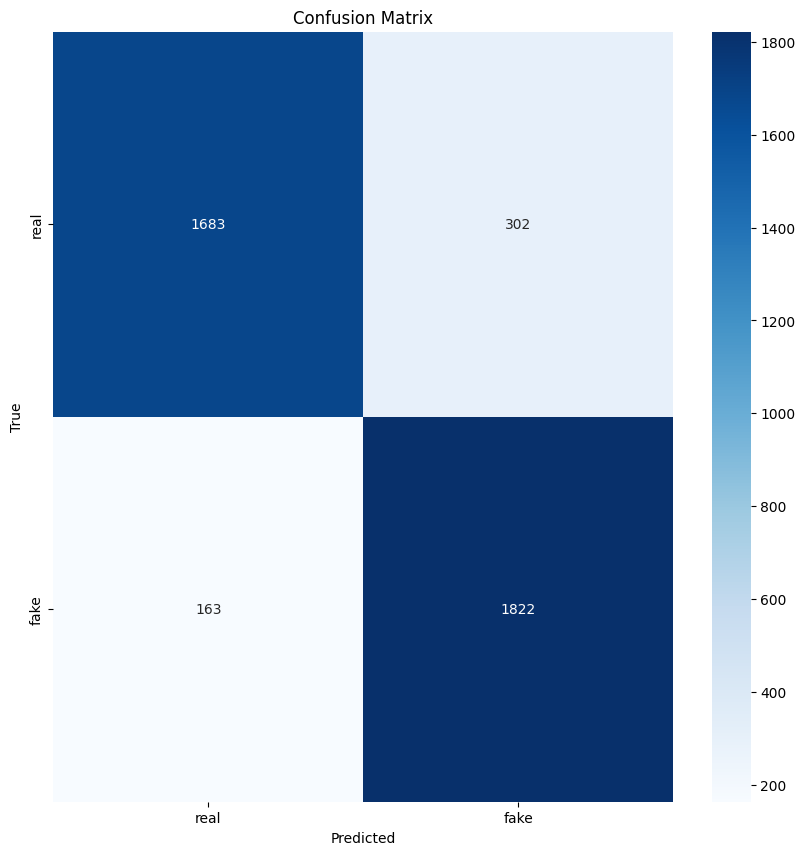

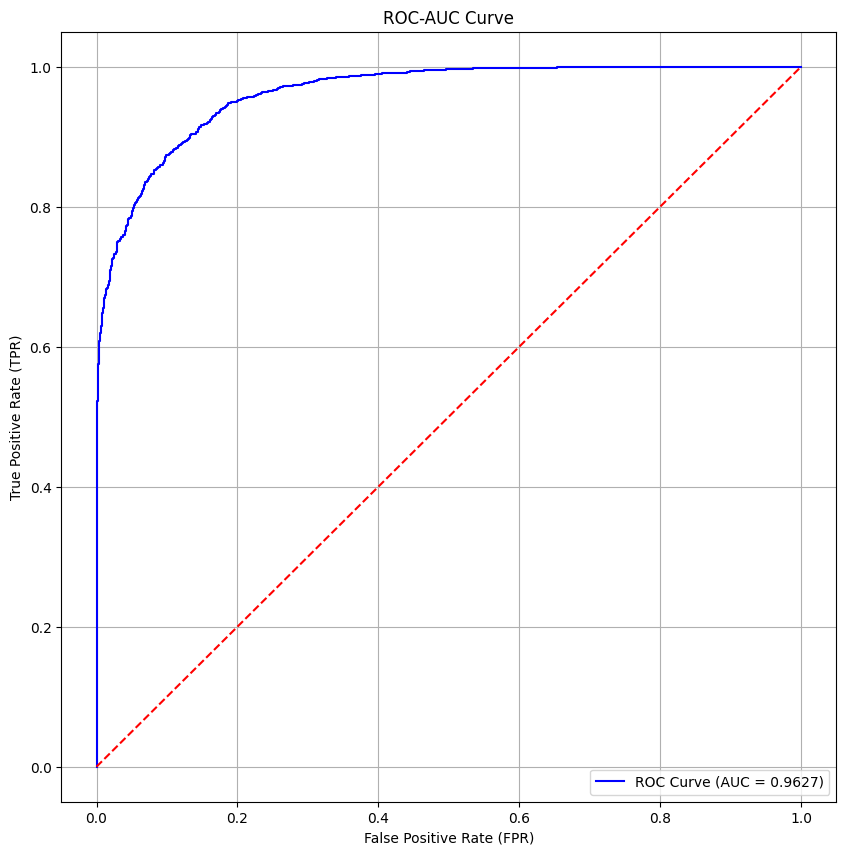

In [28]:
# Evaluate the model on the combined test set (validation + test)
results = evaluate_and_visualize_model(model, combined_test_loader, device)

# Plot the confusion matrix for the combined test set
# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'], save_path='best_model_combined_set_cf.png')

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'], save_path='best_model_combined_set_roc.png')